https://towardsdatascience.com/predicting-hdb-housing-prices-using-neural-networks-94ab708cccf8

In [201]:
import pandas as pd

# Load the training set
train_set_path = './Datasets/train.csv'
data = pd.read_csv(train_set_path)

# Display the first few rows of the training set to understand its structure
data.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,jurong east street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,pasir ris street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,whampoa west,3-room,improved,68.0,yes,1972,1.320502,103.863341,0,bendemeer,kallang,central region,2100


In [202]:
# Split the 'rent_approval_date' into 'year' and 'month'
data['year'] = data['rent_approval_date'].apply(lambda x: x.split('-')[0]).astype(int)
data['month'] = data['rent_approval_date'].apply(lambda x: x.split('-')[1]).astype(int)
data = data.drop(columns='rent_approval_date')

# Standardize the 'flat_type' column
data['flat_type'] = data['flat_type'].str.replace(' ', '-', regex=False)

# Check if all values in 'furnished' and 'elevation' columns are the same
furnished_unique_values = data['furnished'].nunique()
elevation_unique_values = data['elevation'].nunique()

# Drop 'furnished' and 'elevation' columns if all values are the same
if furnished_unique_values == 1:
    data = data.drop(columns='furnished')

if elevation_unique_values == 1:
    data = data.drop(columns='elevation')

# Display the changes to verify
data.head(), furnished_unique_values, elevation_unique_values

(              town block            street_name  flat_type      flat_model  \
 0      jurong east   257  jurong east street 24     3-room  new generation   
 1            bedok   119       bedok north road     4-room  new generation   
 2        toa payoh   157     lorong 1 toa payoh     3-room        improved   
 3        pasir ris   250    pasir ris street 21  executive       apartment   
 4  kallang/whampoa    34           whampoa west     3-room        improved   
 
    floor_area_sqm  lease_commence_date  latitude   longitude  \
 0            67.0                 1983  1.344518  103.738630   
 1            92.0                 1978  1.330186  103.938717   
 2            67.0                 1971  1.332242  103.845643   
 3           149.0                 1993  1.370239  103.962894   
 4            68.0                 1972  1.320502  103.863341   
 
              subzone planning_area          region  monthly_rent  year  month  
 0         yuhua east   jurong east     west region

In [203]:
# Identify non-numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

# Analyze the unique values and their counts for each categorical column
categorical_columns_analysis = {col: data[col].nunique() for col in categorical_columns}

categorical_columns_analysis

{'town': 26,
 'block': 2553,
 'street_name': 543,
 'flat_type': 5,
 'flat_model': 19,
 'subzone': 152,
 'planning_area': 29,
 'region': 5}

In [204]:
# Find the unique values in 'planning_area' and 'town'
unique_planning_areas = set(data['planning_area'].unique())
unique_towns = set(data['town'].unique())

# Find the differences between the two sets
unique_in_planning_not_in_town = unique_planning_areas - unique_towns
unique_in_town_not_in_planning = unique_towns - unique_planning_areas

(unique_in_planning_not_in_town, unique_in_town_not_in_planning)

({'downtown core', 'kallang', 'novena', 'outram', 'rochor'},
 {'central', 'kallang/whampoa'})

In [205]:
# Dropping planning area as there is already a redundant column town which is slightly more general
data.drop(columns=['planning_area'], inplace=True)

# Dropping subzone as it is too granular and does not generalize well enough
data.drop(columns=['subzone', 'block', 'street_name'], inplace=True)

data.head()

,town,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,region,monthly_rent,year,month
0,jurong east,3-room,new generation,67.0,1983,1.344518,103.738630,west region,1600,2021,9
1,bedok,4-room,new generation,92.0,1978,1.330186,103.938717,east region,2250,2022,5
2,toa payoh,3-room,improved,67.0,1971,1.332242,103.845643,central region,1900,2022,10
3,pasir ris,executive,apartment,149.0,1993,1.370239,103.962894,east region,2850,2021,8
4,kallang/whampoa,3-room,improved,68.0,1972,1.320502,103.863341,central region,2100,2022,11


In [206]:
# Define the ordinal mapping for flat_type
flat_type_mapping = {
    '1-room': 0,
    '2-room': 1,
    '3-room': 2,
    '4-room': 3,
    '5-room': 4,
    'executive': 5
}

# Apply the ordinal encoding to flat_type
data['flat_type'] = data['flat_type'].map(flat_type_mapping)

# Display the first few rows to confirm the change
data[['flat_type']].head()

,flat_type
0,2
1,3
2,2
3,5
4,2


In [207]:
# Resale price index data
resale_price_index_data = {
    (2023, 'I'): 173.6,
    (2023, 'II'): 176.2,
    (2023, 'III'): 178.5,
    (2022, 'I'): 159.5,
    (2022, 'II'): 163.9,
    (2022, 'III'): 168.1,
    (2022, 'IV'): 171.9,
    (2021, 'I'): 142.2,
    (2021, 'II'): 146.4,
    (2021, 'III'): 150.6,
    (2021, 'IV'): 155.7
}


# Function to determine the quarter based on the month
def get_quarter(month):
    if 1 <= month <= 3:
        return 'I'
    elif 4 <= month <= 6:
        return 'II'
    elif 7 <= month <= 9:
        return 'III'
    else:  # From October to December
        return 'IV'


# Apply the mapping to the dataset
data['resale_price_index'] = data.apply(
    lambda row: resale_price_index_data.get((row['year'], get_quarter(row['month']))), axis=1
)

# Check if the resale price index was successfully encoded
data[['year', 'month', 'resale_price_index']].head()

,year,month,resale_price_index
0,2021,9,150.6
1,2022,5,163.9
2,2022,10,171.9
3,2021,8,150.6
4,2022,11,171.9


#Determine whether to drop the 'flat_model' column and 'town' column

In [208]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
label_encoders = {}
train_set = data.copy()
print(f"encoding {train_set.select_dtypes(include=['object']).columns}")
for column in train_set.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    train_set[column] = label_encoders[column].fit_transform(train_set[column])

# Separate features and target variable
X = train_set.drop('monthly_rent', axis=1)
y = train_set['monthly_rent']

# Initialize random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Map feature importances to their corresponding column names
feature_importance_dict = dict(zip(X.columns, feature_importances))

# Sort the feature importances in descending order
sorted_feature_importances = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

sorted_feature_importances

encoding Index(['town', 'flat_model', 'region'], dtype='object')


KeyboardInterrupt: 

In [ ]:
# Drop 'flat_model' as we have a more correlated feature 'flat_type'
data.drop(columns=['flat_model'], inplace=True)

# Drop 'region' as it is not a useful feature, although 'town' is a less correlated feature, we will be using that to tag schools(top schools) to a region
data.drop(columns=['region'], inplace=True)

data.head()

In [ ]:
# Load the datasets
file_path_ranking = './Datasets/auxiliary-data/sg-primary-schools_2022_ranking.csv'
file_path_schools = './Datasets/auxiliary-data/sg-primary-schools.csv'

# Read the school ranking data
school_ranking_data = pd.read_csv(file_path_ranking)
# Read the general primary schools data
primary_schools_data = pd.read_csv(file_path_schools)

# Display the first few rows of both dataframes
school_ranking_data.head(), primary_schools_data.head()

In [ ]:
# Correctly merging the ranking data with the primary schools data
merged_schools_data_corrected = primary_schools_data.merge(school_ranking_data,
                                                           left_on='name',
                                                           right_on='School Name',
                                                           how='left')

# Schools that are missing from the ranking list (where Rank is NaN)
missing_schools_corrected = merged_schools_data_corrected[merged_schools_data_corrected['Rank'].isna()].copy()

# Assign the next available ranks to the missing schools
next_rank_corrected = school_ranking_data['Rank'].max() + 1
missing_schools_corrected['Rank'] = range(next_rank_corrected, next_rank_corrected + len(missing_schools_corrected))
missing_schools_corrected['School Name'] = missing_schools_corrected['name']

# Append the missing schools with their new ranks to the school ranking data
final_school_ranking_data_corrected = pd.concat(
    [school_ranking_data, missing_schools_corrected[['School Name', 'Rank']]])

# Sort by Rank to integrate the newly added schools
final_school_ranking_data_corrected = final_school_ranking_data_corrected.sort_values(by='Rank').reset_index(drop=True)

# Add latitude and longitude for all schools
final_school_ranking_with_location = final_school_ranking_data_corrected.merge(
    primary_schools_data, left_on='School Name', right_on='name', how='left')

# Select relevant columns to display
final_schools_data_to_display = final_school_ranking_with_location[
    ['Rank', 'School Name', 'latitude', 'longitude']
]

# Display the schools that were missing and their assigned ranks, and the first few rows of the final ranking with location
missing_schools_corrected[['name', 'Rank', 'latitude', 'longitude']], final_schools_data_to_display.head()

In [ ]:
final_school_ranking_with_location.to_csv('./Datasets/auxiliary-data/final_school_ranking_with_location.csv',
                                          index=False)

In [ ]:
from sklearn.neighbors import BallTree
import numpy as np


# Function to convert degrees to radians
def radians(series):
    return np.radians(series)


# Create a BallTree object for the towns in the real estate dataset
coords_train_set = np.stack((radians(data['latitude']), radians(data['longitude'])), axis=-1)
ball_tree = BallTree(coords_train_set, metric='haversine')

# Convert school locations to radians for the BallTree query
coords_schools = np.stack((radians(final_school_ranking_with_location['latitude']),
                           radians(final_school_ranking_with_location['longitude'])), axis=-1)

# Find the nearest town for each school
distances, indices = ball_tree.query(coords_schools, k=1)
final_school_ranking_with_location['nearest_town_index'] = indices.flatten()

# Map the nearest town index to the actual town name
final_school_ranking_with_location['nearest_town'] = \
data.iloc[final_school_ranking_with_location['nearest_town_index']]['town'].values

# Calculate the average school rank for each town
average_school_rank_by_town = final_school_ranking_with_location.groupby('nearest_town')['Rank'].mean().reset_index()
average_school_rank_by_town.rename(columns={'Rank': 'average_school_rank'}, inplace=True)

# Merge the average school rank with the data set
data = data.merge(average_school_rank_by_town,
                  left_on='town',
                  right_on='nearest_town',
                  how='left')

# Drop the extra 'nearest_town' column as it's redundant
data.drop('nearest_town', axis=1, inplace=True)

# Display the updated train set with the school rank and the average school ranks by town
data[['town', 'average_school_rank']].head(), average_school_rank_by_town.head()

In [ ]:
average_school_rank_by_town.to_csv('./Datasets/auxiliary-data/average_school_rank_by_town.csv', index=False)

In [197]:
# Identify non-numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['town']

In [198]:
# drop 'town' as we have already encoded it
data.drop(categorical_columns, axis=1, inplace=True)
data.to_csv('./Datasets/train_cleaned_110523.csv', index=False)

In [199]:
# check the skewness of the distribution
skewness = data['monthly_rent'].skew()
skewness

0.864935378264997

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

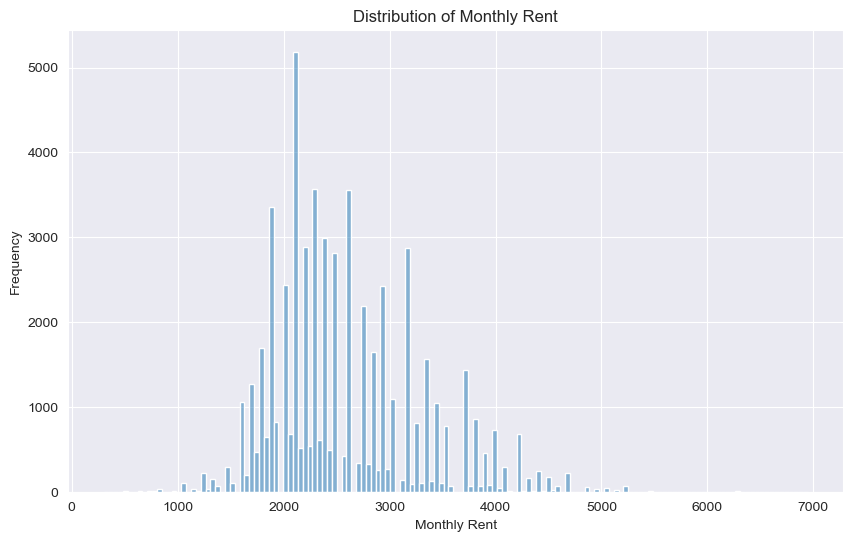

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the target variable 'monthly_rent'
plt.figure(figsize=(10, 6))
plt.title('Distribution of Monthly Rent')
plt.xlabel('Monthly Rent')
plt.ylabel('Frequency')
sns.histplot(data['monthly_rent'], kde=True)
plt.show()